## Pymoosh and Nevergrad for the inverse design of multilayered structures

This colab is based on Pymoosh (https://github.com/AnMoreau/PyMoosh) and Nevergrad (https://github.com/facebookresearch/nevergrad). If you like our codes, please consider putting a star on our githubs :-)

Context = shape optimization for photonics


# Here we do installations, imports and parametrizations. You might want to create your own copy of this colab (File, Save a copy). Edit here for parametrizing your run, before clicking on "run everything" in the "run" menu.

In [1]:
!pip install pymoosh
!pip install bayes-optim==0.2.5.5
!pip install nevergrad

# Let us get rid of some deprecation warning in SkLearn.
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore")


, conv=keras.layers.Conv1D


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 KB 1.4 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Using cached sklearn-0.0.tar.gz (1.1 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=f6a44cac7a7b836d74ff971d23b8fca4fa4b6f93ec1e4fcb75919b4059086ac6
  Stored in directory: /home/hans/.cache/pip/wheels/9b/13/01/6f3a7fd641f90e1f6c8c7cded057f3394f451f340371c68f3d
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=955cf6541b51ce22dc3ca12450b752b49427f01b87e419f429d3db74e6ca9e60
  Stored in directory: /home/hans/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built sklearn pyDOE
  Attempting uninstall: sklearn
    Found existing installation: sklear

'conv=keras.layers.Conv1D'

In [2]:
# Helper function.
def doint(s):  # Converting a string into an int.
   return 7 + sum([ord(c)*i for i, c in enumerate(s)])

def get_color(o):  # Converting a string into a color.
  colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
  #c = {"CMA": "c", "QODE": "r", "BFGS": "g", "LBFGSB": "b", "GradBFGS": "k", "QNDE": "m"}[o]
  algs = ["CMA", "QODE", "BFGS", "LBFGSB", "GradBFGS", "QNDE"]
  if o in algs:
      return colors[algs.index(o)]
  return colors[doint(o) % len(colors)]


# Please modify the parameters below at your best convenience.
maximum_time_per_run_in_seconds = 600  # Maximum number of seconds per run (then: interruption).
num_experiments = 15  # Number of times we reproduce each experiments.
maximum_optimization_overhead = 5  # Maximum ratio between the cost and the cost of the objective function only.

# List of optimization methods in the extended setup.
list_optims = ["ChainMetaModelSQP", "MetaModel", "SQP", "CMA", "DE", "RotatedTwoPointsDE", "OnePlusOne", "QODE", "QNDE", "TwoPointsDE", "PSO", "GeneticDE", "NelderMead", "Cobyla" ,"Powell"]
list_optims = ["CMA", "QODE", "QNDE", "BFGS", "PCABO", "BO", "LBFGSB"]
# if you want more, you might add:  list_optims += ["BayesOptimBO", "PCABO", "RCobyla", "Shiwa", "CMandAS2", "NGOpt", "NGOptRW"]

# Choice of objective function. List of possibilities readable just below.
obj_name = "photovoltaics"
obj_name = "ellipsometry"
assert obj_name in ["bragg", "photovoltaics", "bigbragg", "bigphotovoltaics", "ellipsometry", "minibragg", "hugephotovoltaics"]
run_performance = False  # Whether we want to run the comparison between various optimization methods.

if obj_name == "bragg":
  nb_layers = 20
  opti_wave = 600
  mat1 = 1.4
  mat2 = 1.8
  min_th = 0 # We don't want negative thicknesses.
  max_th = opti_wave/(2*mat1) # A thickness of lambda/2n + t has the same behaviour as a thickness t

elif obj_name == "bigbragg":
  nb_layers = 40
  opti_wave = 600
  mat1 = 1.4
  mat2 = 1.8
  min_th = 0 # We don't want negative thicknesses.
  max_th = opti_wave/(2*mat1) # A thickness of lambda/2n + t has the same behaviour as a thickness t

elif obj_name == "ellipsometry":
  nb_layers = 1
  min_th = 50
  max_th = 150

elif obj_name == "photovoltaics":
  nb_layers = 10
  min_th = 30
  max_th = 250

elif obj_name == "bigphotovoltaics":
  nb_layers = 20
  min_th = 30
  max_th = 250

elif obj_name == "minibragg":
  nb_layers = 10
  opti_wave = 600
  mat1 = 1.4
  mat2 = 1.8
  min_th = 0 # We don't want negative thicknesses.
  max_th = opti_wave/(2*mat1) # A thickness of lambda/2n + t has the same behaviour as a thickness t

elif obj_name == "hugephotovoltaics":
  nb_layers = 32
  min_th = 30
  max_th = 250

else:
  assert False, f"Unknown objective function {obj_name}"

dim = 2 * nb_layers if "ellipsometry" in obj_name else nb_layers

budget = dim * 1000
if obj_name == "ellipsometry":
  budget = 100

if dim < 15:  # We remove Bayesian optimization from high-dimensional contexts.
  list_optims += ["BO", "PCABO"]

# All problems.
min_ind = 1.1
max_ind = 3

context_string = f"We work on {obj_name}, dim={dim}, budget={budget}, bounds=[{min_th},{max_th}]"
print(context_string)

We work on photovoltaics, dim=10, budget=10000, bounds=[30,250]



# Here we define the Pymoosh objective functions.

In [3]:
import nevergrad as ng
import matplotlib.pyplot as plt
import PyMoosh as pm
import numpy as np

def bragg(x):
  # This cost function corresponds to the problem
  # of maximizing the reflectance, at a given wavelength,
  # of a multilayered structure with alternating refractive
  # indexes. This problem is inspired by the first cases studied in
  # https://www.nature.com/articles/s41598-020-68719-3
  # :-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:
  # The input, x, corresponds to the thicknesses of all the layers, :
  # starting with the upper one.                                    :
  # :-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:-:
  x = list(x)
  n = len(x)
  # Working wavelength
  wl = 600.
  materials = [1,1.4**2,1.8**2]
  stack = [0] + [2,1] * (n//2) + [2]
  thicknesses = [0.] + list(x) + [0.]
  structure = pm.Structure(materials,stack,np.array(thicknesses),verbose = False)
  _, R = pm.coefficient_I(structure,wl,0.,0)
  cost = 1-R
  return cost

# def photovoltaics(x):
#   n = len(x)
#   materials = [1., 2., 3., "SiA"]
#   stack = [0] + [1,2] * (n//2) + [3]
#   thicknesses = [0] + list(x) + [3000]
#   structure = pm.Structure(materials, stack, np.array(thicknesses), verbose = False)
#   incidence = 0
#   pola = 0
#   wl_min = 375
#   wl_max = 750
#   active_lay = len(thicknesses) - 1
#   number_pts = 50
#   eff, curr, curr_max, wl, spectrum, absorb4 = pm.photo(structure, incidence, pola, wl_min, wl_max, active_lay, number_pts)
#   cost = 1 - eff
#   return cost
def photovoltaics(x):
  n = len(x)
  materials = [1., 2., 3., "SiA"]
  stack = [0] + [1,2] * (n//2) + [3]
  thicknesses = [0] + list(x) + [30000]
  structure = pm.Structure(materials, stack, np.array(thicknesses), verbose = False)
  incidence = 0
  pola = 0
  wl_min = 375
  wl_max = 750
  active_lay = len(thicknesses) - 1
  number_pts = 300
  eff, curr, curr_max, wl, spectrum, absorb4 = pm.photo(structure, incidence, pola, wl_min, wl_max, active_lay, number_pts)
  cost = 1 - eff
  return cost

mat = [1.] + [np.random.random()*(max_ind-min_ind) + min_ind for _ in range(nb_layers)] + ["Gold"]
layers = list(range(nb_layers+2))
structure = [0] + [np.random.random()*(max_th-min_th) + min_th for _ in range(nb_layers)] + [0]


angle = 40*np.pi/180
wav_list = np.linspace(400, 800, 100)

WAVELENGTH = 900


def ref_structure(mat, layers, structure, wav_list, angle):
    struct = pm.Structure(mat, layers, structure,verbose = False)
    ellips = np.zeros(len(wav_list), dtype=complex)
    for i, wav in enumerate(wav_list):
        r_s, _, _, _ = pm.coefficient(struct, wav, angle, 0)
        r_p, _, _, _ = pm.coefficient(struct, wav, angle, 1)

        ellips[i] = r_p/r_s
    return ellips, struct

ref_ellips, ellips_structure = ref_structure(mat, layers, structure, wav_list, angle)

def ellipsometry(X, ref_ellips=ref_ellips, wav_list=wav_list, angle=angle, nb_layers=nb_layers):
    mat = [1.] + [x for x in X[:nb_layers]] + ["Gold"]
    layers = [i for i in range(nb_layers+2)]
    structure = np.array([0] + [x for x in X[nb_layers:]] + [0])

    ellips = np.zeros(len(wav_list), dtype=complex)
    interface = pm.Structure(mat, layers, structure, verbose=False)
    for i, wav in enumerate(wav_list):
        r_s, _ = pm.coefficient_I(interface, wav, angle, 0)
        r_p, _ = pm.coefficient_I(interface, wav, angle, 1)

        ellips[i] = r_p/r_s

    return np.sum(np.abs(ellips - ref_ellips))


objective_function = {"bragg": bragg, "bigbragg": bragg, "photovoltaics": photovoltaics, "bigphotovoltaics": photovoltaics, "ellipsometry": ellipsometry}[obj_name]




# Simple running example for DE with Bragg

In [ ]:
if "bragg" in obj_name:

  X_min = np.array([min_th]*nb_layers)
  X_max = np.array([max_th]*nb_layers)


  best, convergence = pm.differential_evolution(bragg, budget, X_min, X_max)

  plt.plot(convergence)
  plt.xlabel("Optimization step")
  plt.ylabel("Cost")
  plt.show()

  def bragg_plot(best):
    # Showing the final spectrum
    materials = [1,mat1**2,mat2**2]
    stack = [0] + [2,1] * (len(best) //2) + [2]
    thicknesses = [0.] + [t for t in best] + [0.]

    bragg_mirror = [opti_wave / (4*np.sqrt(materials[2])), opti_wave / (4*np.sqrt(materials[1]))] * (nb_layers//2)
    bragg_th = [0.] + [t for t in bragg_mirror] + [0.]
    structure = pm.Structure(materials,stack,thicknesses,verbose = False)
    bragg_structure = pm.Structure(materials,stack,bragg_th,verbose = False)

    wavelengths = np.linspace(opti_wave-150, opti_wave+150, 300)
    spectrum = np.zeros_like(wavelengths)
    bragg_spectrum = np.zeros_like(wavelengths)
    for i, wav in enumerate(wavelengths):
      _,_,R,_ = pm.coefficient(structure,wav,0.,0)
      spectrum[i] = R
      _,_,R,_ = pm.coefficient(bragg_structure,wav,0.,0)
      bragg_spectrum[i] = R

  # plt.plot(wavelengths, spectrum, label="Optimized structure")
    plt.plot(wavelengths, bragg_spectrum, label="Bragg mirror")
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Reflectivity")
    plt.legend()
    plt.show()

    structure.plot_stack(wavelength=opti_wave)
    bragg_structure.plot_stack(wavelength=opti_wave)

  bragg_plot(best)


# Simple running example for DE with Photovoltaics





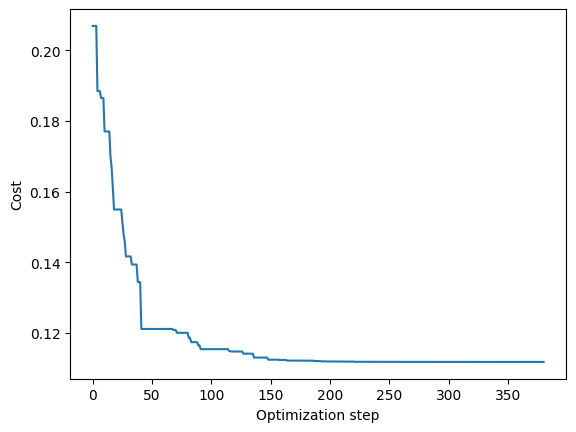

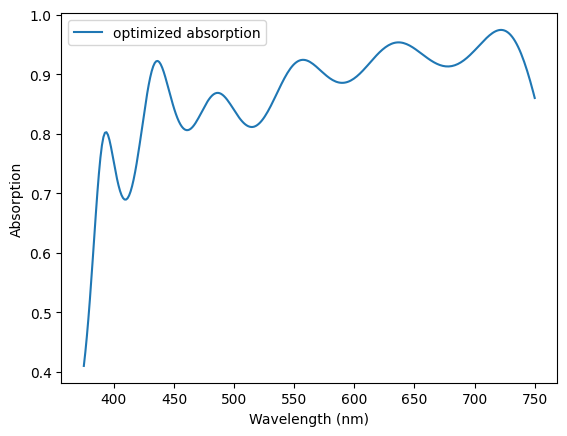

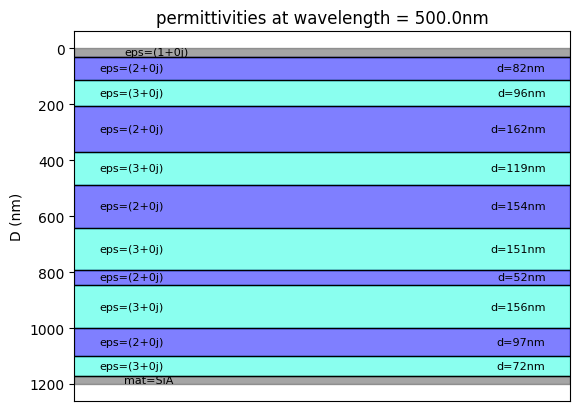

In [ ]:
if "photovoltaics" in obj_name:

  X_min = np.array([min_th]*nb_layers)
  X_max = np.array([max_th]*nb_layers)

  best, convergence = pm.differential_evolution(photovoltaics, budget, X_min, X_max)

  plt.figure(2)
  plt.plot(convergence)
  plt.xlabel("Optimization step")
  plt.ylabel("Cost")
  plt.show()


  # def photovoltaics_plot(best):
  #   # Showing the final spectrum
  #   materials = [1., 2., 3., "SiA"]
  #   stack = [0] + [1,2] * (len(best) // 2) + [3]
  #   thicknesses = [0.] + [t for t in best] + [3000.]

  #   structure = pm.Structure(materials, stack, thicknesses, verbose = False)
  #   incidence = 0
  #   pola = 0
  #   wl_min = 375
  #   wl_max = 750
  #   active_lay = len(thicknesses) - 1
  #   number_pts = 100
  #   eff, curr, curr_max, wl, spectrum, absorb_opt = pm.photo(structure, incidence, pola, wl_min, wl_max, active_lay, number_pts)
  #   #print("\n Conversion efficiency",eff,"\n Short-circuit current \n   ",curr,"mA/cm^2 \n Theoretical max. current for this wavelength range\n   ",curr_max,"mA/cm^2")

  #   ### structure de reference
  #   adapt_imp_air = [79,102]
  #   adapt_imp_si = [100,70]
  #   dbr = [147, 120]* (len(best)//2 - 2)
  #   hauteur = [0] + adapt_imp_air + dbr + adapt_imp_si + [3000]

  #   Epsilon = [1.,2.,3., "SiA"]

  #   Type = [0] + [1,2] *  (len(best)//2)  + [3]
  #   print(Type)

  #   advanced_AR = pm.Structure(Epsilon, Type, hauteur)
  #   active_layer = len(hauteur) -1

  #   efficiency,current,current_max,wl,spectrum,absorb4 = pm.photo(advanced_AR,0.,0.,375.,750.,[active_layer],number_pts)

  #   plt.plot(wl, absorb_opt, label = "optimized absorption")
  #   plt.plot(wl, absorb4, label = "reference absorption")
  #   plt.xlabel("Wavelength (nm)")
  #   plt.ylabel("Absorption")
  #   plt.legend()
  #   plt.show()

  #   thicknesses_for_image = [t for t in best]
  #   hauteur_for_image = adapt_imp_air + dbr + adapt_imp_si
  #   structure_image = pm.Structure(materials, stack, thicknesses_for_image, verbose = False)
  #   advanced_AR_image = pm.Structure(Epsilon, Type, hauteur_for_image, verbose = False)
  #   structure_image.plot_stack()
  #   advanced_AR_image.plot_stack()

def photovoltaics_plot(best):
    # Showing the final spectrum
    materials = [1., 2., 3., "SiA"]
    stack = [0] + [1,2] * (len(best) // 2) + [3]
    thicknesses = [0.] + [t for t in best] + [30000.]

    structure = pm.Structure(materials, stack, thicknesses, verbose = False)
    incidence = 0
    pola = 0
    wl_min = 375
    wl_max = 750
    active_lay = len(thicknesses) - 1
    number_pts = 300
    eff, curr, curr_max, wl, spectrum, absorb_opt = pm.photo(structure, incidence, pola, wl_min, wl_max, active_lay, number_pts)

    plt.plot(wl, absorb_opt, label = "optimized absorption")
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Absorption")
    plt.legend()
    plt.show()

    thicknesses_for_image = [30] + [t for t in best] + [30]
    structure_image = pm.Structure(materials, stack, thicknesses_for_image, verbose = False)
    structure_image.plot_stack()

photovoltaics_plot(best)


# Simple running example for DE with Ellipsometry

In [5]:
obj_name = ["ellipsometry"]

if "ellipsometry" in obj_name:  # See parametrization at the top of the present colab.
  nb_runs = 20

  X_min = np.array([min_ind] * (nb_layers) +  [min_th] * (nb_layers))
  X_max = np.array([max_ind] * (nb_layers) +  [max_th] * (nb_layers))

  convs = []
  bests = []
  scores = []
  for i in range(nb_runs):
    print(f"{i+1} / {nb_runs}")
    best, convergence = pm.differential_evolution(ellipsometry, budget, X_min, X_max)
    bests.append(best)
    convs.append(convergence)
    scores.append(convergence[-1])

  order = np.argsort(scores)
  print(order)

  # Last structure
  mat = [1.] + [x for x in best[:nb_layers]] + ["Gold"]
  layers = [i for i in range(nb_layers+2)]
  structure = [0] + [x for x in best[nb_layers:]] + [0]
  best_struct = pm.Structure(mat, layers, structure)

  for i in range(nb_runs):
    plt.plot(convs[i])
  plt.xlabel("Optimization step")
  plt.ylabel("Cost")
  plt.show()

  # Best ever structure
  best = bests[order[0]]
  mat = [1.] + [x for x in best[:nb_layers]] + ["Gold"]
  layers = [i for i in range(nb_layers+2)]
  structure = [0] + [x for x in best[nb_layers:]] + [0]
  best_struct = pm.Structure(mat, layers, structure)


  ellips_structure.plot_stack()
  best_struct.plot_stack()

1 / 20


# Performance comparisons

Here we compare different optimization methods.
The list of these methods is in the top code block.
The objective function used in the comparison is specified in the top code block.
The next code block does the plottings.

In [ ]:
if run_performance:

  import time
  # Now we run all algorithms and we store results in dictionaries.
  scores = {}
  computational_cost = {}
  yval = {}
  for optim_name in list_optims:
    print("Running ", optim_name)
    scores[optim_name] = []
    computational_cost[optim_name] = []
    yval[optim_name] = []
    for xp in range(num_experiments):
      # We slightly randomize the upper bound, for checking the robustness.
      r = 0. if xp == 0 else (np.random.rand() - 0.5) * (max_th - min_th) * .01
      if obj_name == "ellipsometry":
        array1 = ng.p.Array(shape=(nb_layers,), lower=min_ind, upper=max_ind)
        array1.set_mutation((max_ind - min_ind) / 6.).set_standardized_data([-(max_ind - min_ind) / 2] * nb_layers)
        array2 = ng.p.Array(shape=(nb_layers,), lower=min_th, upper=max_th - r)
        array2.set_mutation((max_th - min_th) / 6.).set_standardized_data([-(max_th - r - min_th) / 2] * nb_layers),
        instrumentation = ng.p.Instrumentation(
            array1,
            array2,
        )
      else:
        instrumentation = ng.p.Array(shape=(dim,), lower=min_th, upper=max_th - r)
        instrumentation.set_mutation((max_th - min_th) / 6.).set_standardized_data([-(max_th - r - min_th) / 2]*dim)
      optim = ng.optimizers.registry[optim_name](instrumentation, budget)
      best_y = float("inf")
      t0 = time.time()
      xval = []
      obj_time = float("inf")
      for k in range(budget):
        if time.time() - t0 < min(maximum_time_per_run_in_seconds, maximum_optimization_overhead * (k+1) * obj_time):
          x = optim.ask()
          t1 = time.time()
          val = x.value
          if obj_name == "ellipsometry":
            val = list(val[0][0]) + list(val[0][1])
          elif obj_name == "ellipsometry2":
            val = [val[0][i][0] for i in range(len(val[0]))]
          y = objective_function(val)
          obj_time = float(time.time() - t1)
          optim.tell(x, y)
          if y < best_y:
            best_y = y
        if int(np.log2(k + 1) + .999999) == int(np.log2((k + 1))) or k == budget - 1:
          xval += [k+1]
          if len(yval[optim_name]) < len(xval):
            yval[optim_name] += [[]]
          yval[optim_name][len(xval)-1] += [best_y]
      computational_cost[optim_name] += [time.time() - t0]
      scores[optim_name] += [best_y]


# Below a code block for plotting the results.

In [ ]:
if run_performance:
  import matplotlib.pyplot as plt
  plt.rcParams['font.size'] = "20" #str(int(plt.rcParams['font.size']) + 2)
  plt.rcParams['figure.figsize'] = [15, 9]
  plt.rcParams["figure.autolayout"] = True
  from google.colab import files

  angles = [c * 2 * 3.14159 / 10 for c in range(10)] + [0.]

  # Plotting the convergence curves, NOT aggregated.
  plt.clf()
  np.random.seed(7)
  for o in sorted(scores, key=lambda x: -np.sum(scores[x]) / len(scores[x])):
    print(o, xval, yval[o])
    yval_mean = [np.sum(yval[o][i]) / len(yval[o][i]) for i in range(len(yval[o]))]
    yval_std = [np.std(yval[o][i]) / np.sqrt(len(yval[o][i]) - 1) for i in range(len(yval[o]))]
    c = get_color(o)
    s = np.random.RandomState(doint(o)).choice([6, 10, 13])
    m = np.random.RandomState(doint(o)).choice(["o", "^", "v", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "X", "D", "d", "|", "_"])

    plt.semilogx(xval, yval_mean, label=o, c=c,
              marker=m, markersize=s)
    for k in range(len(yval[o][0])):
      yval_k = [yval[o][i][k] for i in range(len(yval[o]))]
      plt.semilogx(xval, yval_k, c=c, marker=m, markersize=s)
    #plt.annotate(o, (xval[-1], yval_mean[-1]), rotation=30)
    for i in range(len(xval)):
      #plt.plot([xval[i], xval[i]], [yval_mean[i] - yval_std[i], yval_mean[i] + yval_std[i]], c="k", marker="+")
      plt.plot([xval[i] * (1. + .1 * np.cos(theta)) for theta in angles], [yval_mean[i] + yval_std[i] * np.sin(theta) for theta in angles], c="grey", linestyle="dashed")
  plt.legend()
  plt.title(context_string + "\n Convergence curves")
  plt.tight_layout()
  plt.savefig("fcc" + obj_name + ".png")
  files.download("fcc" + obj_name + ".png")
  plt.savefig("fcc" + obj_name + ".svg")
  files.download("fcc" + obj_name + ".svg")
  plt.pause(0.05)

  # Plotting the convergence curves, aggregated.
  plt.clf()
  np.random.seed(7)
  for o in sorted(scores, key=lambda x: -np.sum(scores[x]) / len(scores[x])):
    print(o, xval, yval[o])
    yval_mean = [np.sum(yval[o][i]) / len(yval[o][i]) for i in range(len(yval[o]))]
    yval_std = [np.std(yval[o][i]) / np.sqrt(len(yval[o][i]) - 1) for i in range(len(yval[o]))]
    c = get_color(o)
    s = np.random.RandomState(doint(o)).choice([6, 10, 13])
    m = np.random.RandomState(doint(o)).choice(["o", "^", "v", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "X", "D", "d", "|", "_"])
    plt.semilogx(xval, yval_mean, label=o, c=c, marker=m, markersize=s)
    #plt.annotate(o, (xval[-1], yval_mean[-1]), rotation=30)
    for i in range(len(xval)):
      #plt.plot([xval[i], xval[i]], [yval_mean[i] - yval_std[i], yval_mean[i] + yval_std[i]], c="k", marker="+")
      plt.semilogx([xval[i] * (1. + .1 * np.cos(theta)) for theta in angles], [yval_mean[i] + yval_std[i] * np.sin(theta) for theta in angles], c="grey", linestyle="dashed")
  plt.legend()
  plt.title(context_string + "\n Convergence curves")
  plt.tight_layout()
  plt.savefig("cc" + obj_name + ".png")
  files.download("cc" + obj_name + ".png")
  plt.savefig("cc" + obj_name + ".svg")
  files.download("cc" + obj_name + ".svg")
  plt.pause(0.05)

  # Now pretty plotting with score on the x-axis and comp. time on the y-axis.
  plt.clf()
  maxi = max([np.sum(scores[o]) / len(scores[o]) for o in scores])
  mini = min([np.sum(scores[o]) / len(scores[o]) for o in scores])
  width = maxi - mini
  for i, o in enumerate(sorted(scores, key=lambda x: np.sum(computational_cost[x]) / len(scores[x]))):
    avg_score = np.sum(scores[o]) / len(scores[o])
    std_score = np.std(scores[o]) / np.sqrt(len(scores[o]))
    avg_time = np.sum(computational_cost[o]) / len(computational_cost[o])
    print(o, avg_score, "+-", std_score, "   in time ", avg_time)
    plt.annotate("     " + o, (avg_score, avg_time), rotation=0. + 70. * i / len(scores))
    plt.loglog([avg_score], [avg_time], '*')
    plt.loglog([avg_score-std_score, avg_score+std_score], [avg_time, avg_time], '-')
    plt.xlabel("Score")
    plt.ylabel("Comp. time")
  plt.title(context_string + "\n Loss vs computational cost")
  plt.tight_layout()
  plt.savefig("comptime" + obj_name + ".png")
  files.download("comptime" + obj_name + ".png")
  plt.savefig("comptime" + obj_name + ".svg")
  files.download("comptime" + obj_name + ".svg")
  plt.pause(0.05)

  # Boxplots for all algorithms.
  plt.clf()
  names = sorted(scores.keys(), key=lambda x: np.sum(scores[x]) / len(scores[x]))
  plt.boxplot([scores[o] for o in names])
  x = []
  y = []
  for u, k in enumerate(names):
    for i, s in enumerate(scores[k]):
      x += [u + 0.9 + np.random.rand() * .2]
      y += [sorted(scores[k])[i]]
  plt.plot(x, y, "*")
  import pylab
  ax = plt.gca()
  ax.set_xticklabels(ax.get_xticks(), rotation = 45, ha="right")
  pylab.xticks(range(1, len(names)+1), names)
  plt.title(f"Performance of different algorithms for {obj_name}\n with budget {budget} and dim {dim}\n (lower the better)")
  plt.tight_layout()
  plt.savefig("bp" + obj_name + ".png")
  files.download("bp" + obj_name + ".png")
  plt.savefig("bp" + obj_name + ".svg")
  files.download("bp" + obj_name + ".svg")
  plt.pause(0.05)

  # And consistency plots for all algorithms.
  plt.clf()
  names = sorted(scores.keys(), key=lambda x: -np.max(scores[x]))
  for k in names:
    c = get_color(k)
    s = np.random.RandomState(doint(k)).choice([6, 10, 13])
    m = np.random.RandomState(doint(k)).choice(["o", "^", "v", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "X", "D", "d", "|", "_"])
    plt.plot(range(len(scores[k])), sorted(scores[k], key=lambda x: x), label=k, c=c, marker=m, markersize=s)
  plt.legend()
  plt.title(f"{context_string}\nScores of the different runs of each method, sorted. The lower the better.")
  plt.tight_layout()
  plt.savefig("q" + obj_name + ".png")
  files.download("q" + obj_name + ".png")
  plt.savefig("q" + obj_name + ".svg")
  files.download("q" + obj_name + ".svg")